In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
ds = pd.read_excel("C:\\Users\\Ritik_Naroliya\\Downloads\\Online Retail.xlsx")

In [4]:
ds.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
# data cleaning
print(ds.info())
print(ds.shape)
print(ds.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
(541909, 8)
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [7]:
ds = ds.dropna()
print(ds.info())
print(ds.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB
None
(406829, 8)


#### What is RFM?

##### R(Recency): Number of days since last purchase

##### F(Frequency): Number of transactions

##### M (Monetary): Total amount of transaction (revenue contributed)

In [10]:
# data preprocessing
ds['CustomerID'] = ds['CustomerID'].astype(str)
ds['Amount'] = ds['Quantity']*ds['UnitPrice']
rfm_ds_m = ds.groupby('CustomerID')['Amount'].sum()
rfm_ds_m.reset_index()
rfm_ds_m.columns = ['CustomerID','Amount']
print(rfm_ds_m)

CustomerID
12346.0       0.00
12347.0    4310.00
12348.0    1797.24
12349.0    1757.55
12350.0     334.40
            ...   
18280.0     180.60
18281.0      80.82
18282.0     176.60
18283.0    2094.88
18287.0    1837.28
Name: Amount, Length: 4372, dtype: float64


In [11]:
rfm_ds_f = ds.groupby('CustomerID')['InvoiceNo'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID','Frequency']
print(rfm_ds_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4367    18280.0         10
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70

[4372 rows x 2 columns]


In [16]:
ds['InvoiceDate'] = pd.to_datetime(ds['InvoiceDate'],format='%d-%m-%y %H:%M')
max_date = max(ds['InvoiceDate'])
ds['Diff'] = max_date = ds['InvoiceDate']
rfm_ds_p = ds.groupby('CustomerID')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID','Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.day
print(rfm_ds_p)

     CustomerID  Diff
0       12346.0    18
1       12347.0     7
2       12348.0    16
3       12349.0    21
4       12350.0     2
...         ...   ...
4367    18280.0     7
4368    18281.0    12
4369    18282.0     5
4370    18283.0     6
4371    18287.0    22

[4372 rows x 2 columns]


In [18]:
rfm_ds_final = pd.merge(rfm_ds_m,rfm_ds_f,on='CustomerID', how='inner')
rfm_ds_final = pd.merge(rfm_ds_final,rfm_ds_p,on='CustomerID', how='inner')
rfm_ds_final.columns = ['CustomerId', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final.head())

  CustomerId   Amount  Frequency  Recency
0    12346.0     0.00          2       18
1    12347.0  4310.00        182        7
2    12348.0  1797.24         31       16
3    12349.0  1757.55         73       21
4    12350.0   334.40         17        2


## Outliers

In [19]:
Q1 = rfm_ds_final.Amount.quantile(0.05)
Q3 = rfm_ds_final.Amount.quantile(0.95)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount >= Q1 - 1.5*IQR) & (rfm_ds_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.05)
Q3 = rfm_ds_final.Recency.quantile(0.95)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency >= Q1 - 1.5*IQR) & (rfm_ds_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.05)
Q3 = rfm_ds_final.Frequency.quantile(0.95)
IQR = Q3-Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency >= Q1 - 1.5*IQR) & (rfm_ds_final.Frequency <= Q3 + 1.5*IQR)]

print(rfm_ds_final.shape)

(4293, 4)


## Scaling

In [20]:
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [21]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.238663,0.001395,0.566667
1,0.478571,0.252441,0.200000
2,0.338703,0.041841,0.500000
3,0.336494,0.100418,0.666667
4,0.257277,0.022315,0.033333


## Model Creation

In [22]:
Kmeans = KMeans(n_clusters=3, max_iter=50)
Kmeans.fit(rfm_ds_scaled)
lbs = Kmeans.labels_
print(Kmeans.labels_)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 1 ... 2 2 1]


C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\clust

<function matplotlib.pyplot.show(close=None, block=None)>

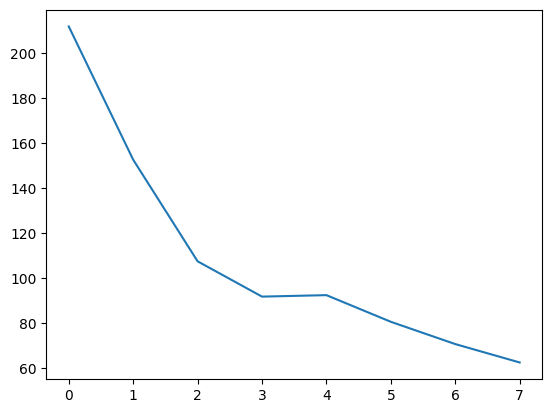

In [24]:
# WSS
wss = []
range_n_clusters = [2,3,4,5,5,6,7,8]
for num_clusters in range_n_clusters:
    Kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    Kmeans.fit(rfm_ds_scaled)
    wss.append(Kmeans.inertia_)
    
plt.plot(wss)
plt.show

In [25]:
rfm_ds_final['Cluster_id'] = lbs
rfm_ds_final.head()

,CustomerId,Amount,Frequency,Recency,Cluster_id
0,12346.0,0.00,2,18,1
1,12347.0,4310.00,182,7,0
2,12348.0,1797.24,31,16,1
3,12349.0,1757.55,73,21,1
4,12350.0,334.40,17,2,2


<AxesSubplot: xlabel='Cluster_id', ylabel='Amount'>

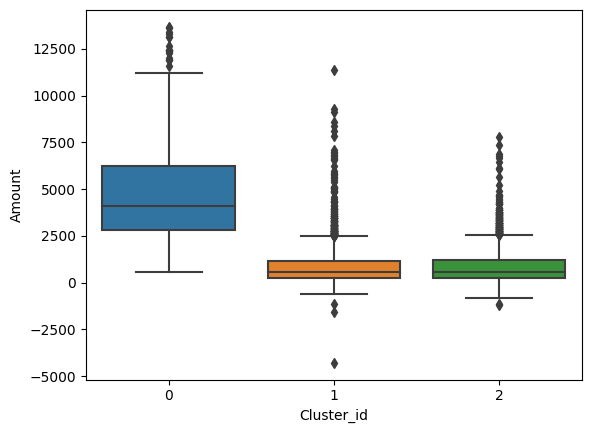

In [36]:
sns.boxplot(x='Cluster_id', y='Amount', data=rfm_ds_final)

<AxesSubplot: xlabel='Cluster_id', ylabel='Frequency'>

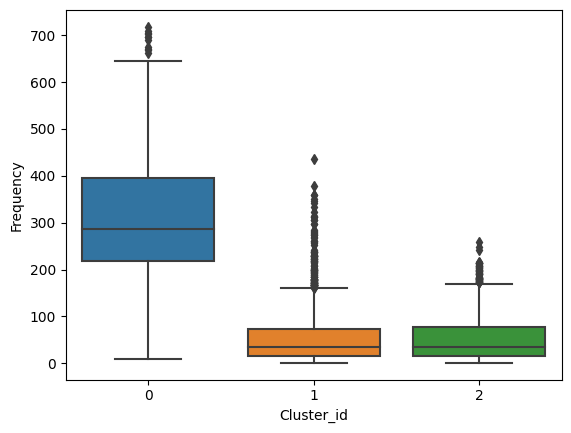

In [37]:
sns.boxplot(x='Cluster_id', y='Frequency', data=rfm_ds_final)

<AxesSubplot: xlabel='Cluster_id', ylabel='Recency'>

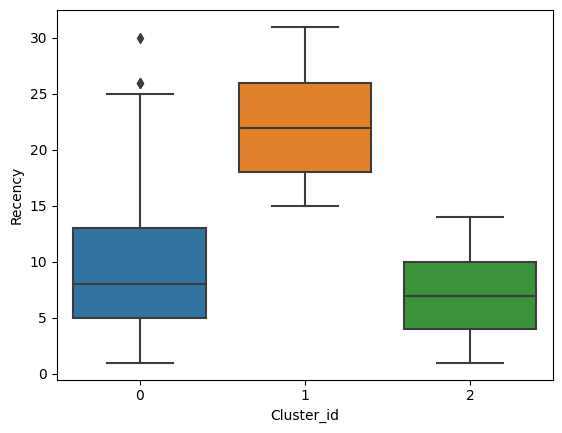

In [38]:
sns.boxplot(x='Cluster_id', y='Recency', data=rfm_ds_final)